UC Irvine's Adult Data Set Notebook
============================

This Jupyter notebook contains the code used during OUAIxHacklahoma workshop for Fall 2021 (December 1st, 2021). Credits given to University of California, Irvine for collecting and organizing the provided ["Adult Data Set"](https://archive.ics.uci.edu/ml/datasets/Adult) dataset.

Objectives
--------------

This jupyter notebook implements a solution to best categorize whether an adult will make _more than_ or _less than_ \$50,000 a year. The dataset uses different attributes to help best predict the goal. The label attribute in this dataset is __income__. Unkown data values will be defined by a `?` symbol

In [1]:
import numpy as np
import pandas as pd

Data Obtention
============

The UCI's Adult dataset is provided in the datasets folder. We use Pandas's `read_csv` function. More formats are supported; read more in pandas [documentation](https://pandas.pydata.org/docs/reference/io.html).

In [2]:
adult = pd.read_csv('datasets/adult.csv')

Data Discovery
============

__It is important for us to gain an understanding of our data before performing any kind of learning or analysis.__ It is important to note that by "Discovery" we mean understanding what attributes and data types the dataset includes. This also includes identifying usefull and useless data attributes (such as dates or indexes). At this stage we want to focus in geting a grasp on what needs to be done next to achieve our goals.

### Look at the dataset's attributes.

In [3]:
adult.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education.num',
       'marital.status', 'occupation', 'relationship', 'race', 'sex',
       'capital.gain', 'capital.loss', 'hours.per.week', 'native.country',
       'income'],
      dtype='object')

### Look at the 7 first and last entries.

In [4]:
adult.head(7)

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
5,34,Private,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States,<=50K
6,38,Private,150601,10th,6,Separated,Adm-clerical,Unmarried,White,Male,0,3770,40,United-States,<=50K


In [5]:
adult.tail(7)

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
32554,32,Private,116138,Masters,14,Never-married,Tech-support,Not-in-family,Asian-Pac-Islander,Male,0,0,11,Taiwan,<=50K
32555,53,Private,321865,Masters,14,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,>50K
32556,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,<=50K
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32558,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32560,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


### See what kind of data the dataset contains.
Note that workclass, education, marital.status, occupation, relationship, race, sex, native.country, and income are type `object`. Since we are using a CSV we can rest assured that we are dealing with a text datatype, most probably a _categorical_ data type. 

Do be careful when using other datatypes such as JSON or pickle, for whole python objects could be in the dataset; thus, requiring further data processing.

In [6]:
adult.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


We can further probe into categorical data by using the `value_counts()` function. This provides us a matrix with values and the number of times they are found in the data. Play around with the other suspected categorical data attributes to further learn more about them.

In [7]:
adult['education'].value_counts()

HS-grad         10501
Some-college     7291
Bachelors        5355
Masters          1723
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           646
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           333
1st-4th           168
Preschool          51
Name: education, dtype: int64

## Dataset Statistics

The `describe()` function provided by Pandas allows us to get a glimpse into the statistical relationships going on in the dataset. This information can be useful to gain a better understanding of the dataset itself.

In [8]:
adult.describe()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


Note that only __6__ attributes are displayed. This is due to the fact that `describe()` only looks at numerical data to produce its statistics.

#### Plotting the dataset

We can further gain knowledge by ploting the dataset. Pay close attention to the distribution! The `hist()` function allows us to plot a historgram. These are very useful when dealing with data that may have different statistical distributions. The `bins` parameter allows us to choose how many "rectangles" to include in a single histogram. The `figsize` allows us to determine the size of the histogram (y, x).

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'fnlwgt'}>],
       [<AxesSubplot:title={'center':'education.num'}>,
        <AxesSubplot:title={'center':'capital.gain'}>],
       [<AxesSubplot:title={'center':'capital.loss'}>,
        <AxesSubplot:title={'center':'hours.per.week'}>]], dtype=object)

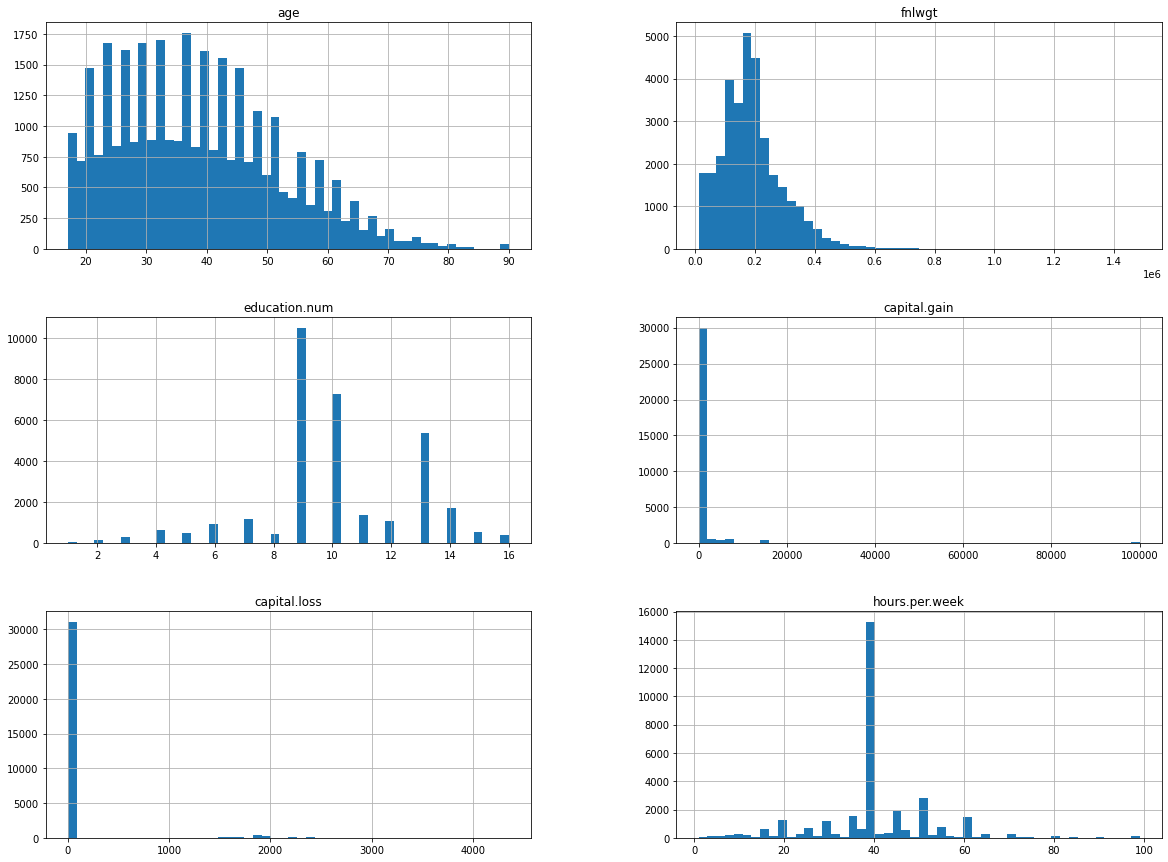

In [9]:
adult.hist(bins=50, figsize=(20, 15))

# Dataset Preparation

Once we have gained a better understanding of the kind of data that we are dealing with, it is important to avoid making assumptions on the dataset. This is because certain attributes may not influence the final prediction as we may think. This is crucial when seeking the best machine learning model.

When working with machine learning, it is very important for us to prepare the dataset for training. This is accomplished by first separating the data into two parts: _Training_ and _Testing_. Doing this will allow us to maintain a neutral position on the dataset and avoid outside bias from interfering with the learning process. Additionally, we will be using the testing dataset after we perform learning in order for us to test how well our model does with unseen data. At the end of the day, we care about a model that can do well with unseen data rather than just the data that it has learned already.

`StratifiedShuffleSplit` is a commonly-used splitting technique to separate the training from the testing sub-datasets. It uses a categorical attribute to keep the best representation among the datasets. In data science, the __80/20__ splitting rule is the most used splitting distribution. We keep 80% for our training data and 20% for our testing data.

### How do we choose which attribute to split on?

Expert advise is best when deciding what attribute to use. In general, it is a good idea to split your dataset using as basis an attribute that may be very important for machine learning; thus, it is benefitial to maintain the best representation of the data possible.

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit

attrib = 'education'
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_i, test_i in split.split(adult, adult[attrib]):
    strat_train_set = adult.loc[train_i]
    strat_test_set = adult.loc[test_i]

Splitted data insights.

In [11]:
strat_train_set.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
7362,71,Self-emp-not-inc,130731,HS-grad,9,Widowed,Adm-clerical,Not-in-family,White,Female,0,0,35,United-States,<=50K
2405,45,Federal-gov,352094,Some-college,10,Married-civ-spouse,Tech-support,Husband,White,Male,7688,0,40,Guatemala,>50K
31414,27,Private,69132,Bachelors,13,Never-married,Tech-support,Not-in-family,White,Male,0,0,37,United-States,<=50K
3002,36,Private,188563,Some-college,10,Married-civ-spouse,Sales,Husband,White,Male,5178,0,50,United-States,>50K
5460,32,Private,86723,HS-grad,9,Never-married,Other-service,Not-in-family,White,Male,0,0,52,United-States,<=50K


In [12]:
strat_test_set.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
18553,22,Private,119359,Bachelors,13,Never-married,Exec-managerial,Own-child,Asian-Pac-Islander,Female,0,0,40,United-States,<=50K
14759,34,Private,294064,Masters,14,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,France,<=50K
25706,19,Private,351802,HS-grad,9,Never-married,Machine-op-inspct,Own-child,White,Male,0,0,35,United-States,<=50K
5457,53,Private,34368,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
10593,21,Private,292264,HS-grad,9,Never-married,Craft-repair,Not-in-family,White,Male,0,0,35,United-States,<=50K


We can appreciate how the distribution in the number of samples is kept across the datasets.

<AxesSubplot:>

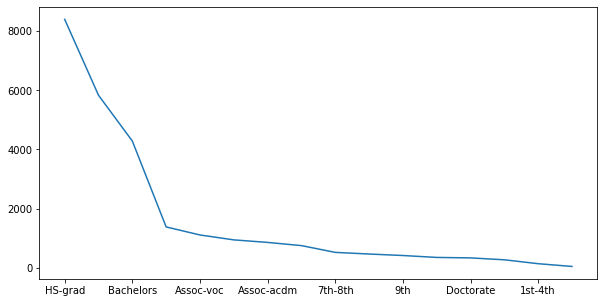

In [13]:
# Train dataset
strat_train_set[attrib].value_counts().plot(figsize=(10, 5))

<AxesSubplot:>

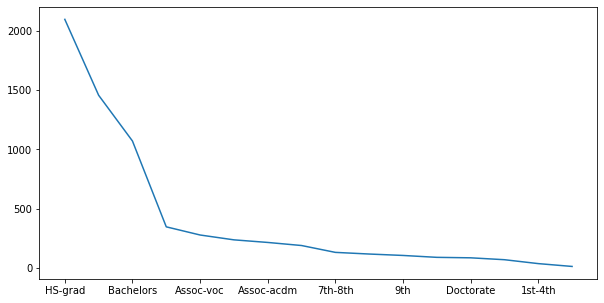

In [14]:
# Test dataset
strat_test_set[attrib].value_counts().plot(figsize=(10, 5))

<AxesSubplot:>

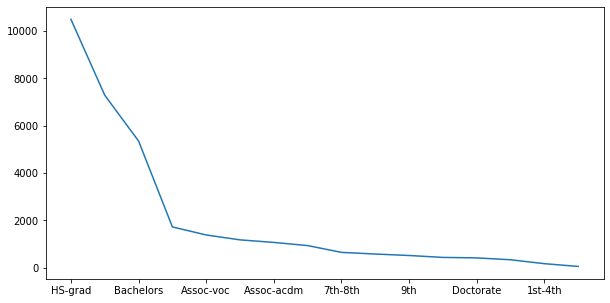

In [15]:
# The distribution is kept if the graphs of the other datasets resemble this one.
adult[attrib].value_counts().plot(figsize=(10, 5))

From now on, __only use the training dataset__ to perform any further data analysis.

## Correlations

Given that in data science we are attempting to find correlations within the data that could give the machine learning model better insights, it is a good idea to check what attributes may be the most useful for this. Note that this will only work with numerical data, thus, we may not be able to use simple Pearson correlation on attributes that are categorical or `object` type.

The most used correlation measure is Pearson correlation. As explained, this only works with numerical data. Note that our label attribute (income) is of type `object`. As explained, this means that we are dealing most likely with a categorical label. We can create a temporal numerical representation of the categorial label by using `OrdinalEncoder`.

In [16]:
from sklearn.preprocessing import OrdinalEncoder

oe = OrdinalEncoder()
strat_train_set['income_ord'] = oe.fit_transform(strat_train_set[['income']])

strat_train_set['income_ord']

7362     0.0
2405     1.0
31414    0.0
3002     1.0
5460     0.0
        ... 
9441     1.0
19605    0.0
24069    0.0
9882     0.0
12284    0.0
Name: income_ord, Length: 26048, dtype: float64

Note how education.num has a correlation of 0.33. 

In [17]:
# Create a correlation matrix
corr_matrix = strat_train_set.corr()
corr_matrix['income_ord'].sort_values(ascending=False)

income_ord        1.000000
education.num     0.338000
age               0.231873
hours.per.week    0.227693
capital.gain      0.223231
capital.loss      0.147074
fnlwgt           -0.011946
Name: income_ord, dtype: float64

Using the OrdinalEncoder, it is possible for us to see the correlation of other attributes.

### Scatter Matrix

We can further visualize any correlations among the data attributes by using a correlation matrix. This can help us better observe the above correlations.

array([[<AxesSubplot:xlabel='age', ylabel='age'>,
        <AxesSubplot:xlabel='capital.gain', ylabel='age'>,
        <AxesSubplot:xlabel='hours.per.week', ylabel='age'>,
        <AxesSubplot:xlabel='capital.loss', ylabel='age'>,
        <AxesSubplot:xlabel='education.num', ylabel='age'>,
        <AxesSubplot:xlabel='fnlwgt', ylabel='age'>,
        <AxesSubplot:xlabel='income_ord', ylabel='age'>],
       [<AxesSubplot:xlabel='age', ylabel='capital.gain'>,
        <AxesSubplot:xlabel='capital.gain', ylabel='capital.gain'>,
        <AxesSubplot:xlabel='hours.per.week', ylabel='capital.gain'>,
        <AxesSubplot:xlabel='capital.loss', ylabel='capital.gain'>,
        <AxesSubplot:xlabel='education.num', ylabel='capital.gain'>,
        <AxesSubplot:xlabel='fnlwgt', ylabel='capital.gain'>,
        <AxesSubplot:xlabel='income_ord', ylabel='capital.gain'>],
       [<AxesSubplot:xlabel='age', ylabel='hours.per.week'>,
        <AxesSubplot:xlabel='capital.gain', ylabel='hours.per.week'>,
      

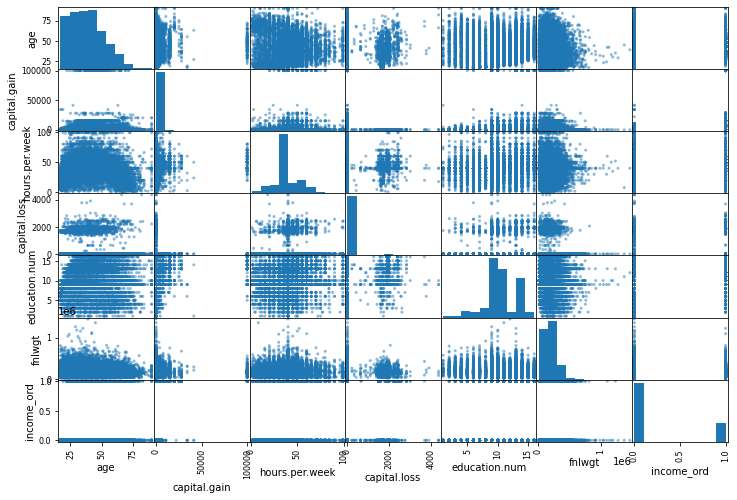

In [18]:
from pandas.plotting import scatter_matrix

attributes = ['age', 'capital.gain', 'hours.per.week', 'capital.loss', 'education.num', 'fnlwgt', 'income_ord']
scatter_matrix(strat_train_set[attributes], figsize=(12, 8))

# Attribute Engineering

Often, it is a good idea to try and combine attributes to further enrich the data of information that may not be there by the individual attributes. This is particularily used for numerical attributes. __Avoid using the label when combining features.__ This is important since the learning model may get information by the label indirectly through the combined attribute. Further, the label will not be available when we actually deploy the model (since we are trying to predict the label to begin with!)

In [19]:
# Create dummy dataset so that we can play more safely with our dataset.
attr_eng_train_set = strat_train_set.copy()
attr_eng_train_set['cap.gain.per.week.hour'] = attr_eng_train_set['capital.gain']/attr_eng_train_set['hours.per.week']
attr_eng_train_set['cap.loss.per.week.hour'] = attr_eng_train_set['capital.loss']/attr_eng_train_set['hours.per.week']
attr_eng_train_set['cap.gain.per.education.num'] = attr_eng_train_set['capital.gain']/attr_eng_train_set['education.num']

Note that `cap.gain.per.week.hour` and `cap.loss.per.week.hour` do not introduce more correlation. On the other hand, `education.num.per.cap.gain` introduces a slightly better correlation that is higher than the other two attributes.

In [20]:
corr_matrix = attr_eng_train_set.corr()
corr_matrix['income_ord'].sort_values(ascending=False)

income_ord                    1.000000
education.num                 0.338000
age                           0.231873
hours.per.week                0.227693
capital.gain                  0.223231
cap.gain.per.education.num    0.200054
cap.gain.per.week.hour        0.190023
capital.loss                  0.147074
cap.loss.per.week.hour        0.066626
fnlwgt                       -0.011946
Name: income_ord, dtype: float64

In [21]:
attr_eng_train_set.describe()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week,income_ord,cap.gain.per.week.hour,cap.loss.per.week.hour,cap.gain.per.education.num
count,26048.000000,2.604800e+04,26048.000000,26048.000000,26048.000000,26048.000000,26048.000000,26048.000000,26048.000000,26048.000000
mean,38.577472,1.898265e+05,10.080851,1088.879876,85.359298,40.449862,0.241209,26.501754,2.344336,96.334635
std,13.606884,1.055267e+05,2.572403,7480.042204,398.869723,12.351080,0.427825,201.918632,18.420078,690.776343
min,17.000000,1.376900e+04,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,28.000000,1.178330e+05,9.000000,0.000000,0.000000,40.000000,0.000000,0.000000,0.000000,0.000000
50%,37.000000,1.780750e+05,10.000000,0.000000,0.000000,40.000000,0.000000,0.000000,0.000000,0.000000
75%,48.000000,2.369078e+05,12.000000,0.000000,0.000000,45.000000,0.000000,0.000000,0.000000,0.000000
max,90.000000,1.455435e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000,11365.000000,1944.000000,41310.000000


Since we are dealing with the stratified data, we will need to add the new attribute we engineered back to the dataset as a whole. In this case, we will add `cap.gain.per.education.num` given that it adds more correlation. Additionally, we will re-shufflesplit the data to account for the fact that `education.num` seems to be the best predictor explored so far.

Further inspection of `education.num` reveals that the attribute, although numerical, is also a categorical attribute. Because of this, we can use it for the StratifiedShuffleSplit.

In [22]:
adult['education.num'].value_counts()

9     10501
10     7291
13     5355
14     1723
11     1382
7      1175
12     1067
6       933
4       646
15      576
5       514
8       433
16      413
3       333
2       168
1        51
Name: education.num, dtype: int64

In [23]:
adult['cap.gain.per.education.num'] = adult['capital.gain']/adult['education.num']
attrib = 'education.num'
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_i, test_i in split.split(adult, adult[attrib]):
    strat_train_set = adult.loc[train_i]
    strat_test_set = adult.loc[test_i]

# Dataset Preparation

Some attributes may have values that may not be useful for learning. In particular, one shall be wary of undefined/invalid values. Oftentimes these values manifest themselves as `NaN` values. In our case, these values are displayed as `?`. This is explained in the dataset's description. This is why it is important to read a dataset description before using. Some authors use different standards when crafting datasets. The three offending attributes in our case are: `workclass, occupation, native.country`

In [24]:
adult['workclass'].value_counts()

Private             22696
Self-emp-not-inc     2541
Local-gov            2093
?                    1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64

In [25]:
adult['occupation'].value_counts()

Prof-specialty       4140
Craft-repair         4099
Exec-managerial      4066
Adm-clerical         3770
Sales                3650
Other-service        3295
Machine-op-inspct    2002
?                    1843
Transport-moving     1597
Handlers-cleaners    1370
Farming-fishing       994
Tech-support          928
Protective-serv       649
Priv-house-serv       149
Armed-Forces            9
Name: occupation, dtype: int64

In [26]:
adult['native.country'].value_counts()

United-States                 29170
Mexico                          643
?                               583
Philippines                     198
Germany                         137
Canada                          121
Puerto-Rico                     114
El-Salvador                     106
India                           100
Cuba                             95
England                          90
Jamaica                          81
South                            80
China                            75
Italy                            73
Dominican-Republic               70
Vietnam                          67
Guatemala                        64
Japan                            62
Poland                           60
Columbia                         59
Taiwan                           51
Haiti                            44
Iran                             43
Portugal                         37
Nicaragua                        34
Peru                             31
Greece                      

There are different ways one can deal with missing data:

1. Remove offending samples.
  - Good when dealing with a small number of samples.
2. Remove attribute.
  - Good when we have too many values missing and we have plenty attributes.
3. Set value.
  - Good when there is high correlations among other attributes or there is enough samples that we can use mean, median, or its ok to set them to 0.
  
In our case, there are several things to consider:

1. `workclass` and `occupation` share the same samples that have missing data. If we remove those particular samples,  we would clean both attributes without having to loose too many samples.
2. `native.country` is a categorical type. Additionally, there is a small number of offending samples. Either labeling them USA or removing them can be good actions. In this case, we will remove them.

In [27]:
# Note that many samples have both workclass and occupation missing!
adult[adult['workclass'] == '?']

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income,cap.gain.per.education.num
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K,0.0
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K,0.0
14,51,?,172175,Doctorate,16,Never-married,?,Not-in-family,White,Male,0,2824,40,United-States,>50K,0.0
24,61,?,135285,HS-grad,9,Married-civ-spouse,?,Husband,White,Male,0,2603,32,United-States,<=50K,0.0
44,71,?,100820,HS-grad,9,Married-civ-spouse,?,Husband,White,Male,0,2489,15,United-States,<=50K,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32533,35,?,320084,Bachelors,13,Married-civ-spouse,?,Wife,White,Female,0,0,55,United-States,>50K,0.0
32534,30,?,33811,Bachelors,13,Never-married,?,Not-in-family,Asian-Pac-Islander,Female,0,0,99,United-States,<=50K,0.0
32541,71,?,287372,Doctorate,16,Married-civ-spouse,?,Husband,White,Male,0,0,10,United-States,>50K,0.0
32543,41,?,202822,HS-grad,9,Separated,?,Not-in-family,Black,Female,0,0,32,United-States,<=50K,0.0


In [28]:
adult[adult['native.country'] == '?']

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income,cap.gain.per.education.num
9,41,Private,70037,Some-college,10,Never-married,Craft-repair,Unmarried,White,Male,0,3004,60,?,>50K,0.0
18,22,Private,119592,Assoc-acdm,12,Never-married,Handlers-cleaners,Not-in-family,Black,Male,0,2824,40,?,>50K,0.0
65,60,Self-emp-inc,226355,Assoc-voc,11,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,2415,70,?,>50K,0.0
86,39,Self-emp-not-inc,218490,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,2415,50,?,>50K,0.0
87,43,Federal-gov,156996,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,2415,55,?,>50K,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32459,44,Self-emp-inc,71556,Masters,14,Married-civ-spouse,Sales,Husband,White,Male,0,0,50,?,>50K,0.0
32476,58,Self-emp-inc,181974,Doctorate,16,Never-married,Prof-specialty,Not-in-family,White,Female,0,0,99,?,<=50K,0.0
32498,42,Self-emp-not-inc,217597,HS-grad,9,Divorced,Sales,Own-child,White,Male,0,0,50,?,<=50K,0.0
32515,39,Private,107302,HS-grad,9,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,45,?,>50K,0.0


#### Clean `workclass`, `occupation`, `native.country`

We keep only the samples that do not have `?` as values. We only loose __2399__ data samples (~7%).

In [29]:
adult = adult[adult['workclass'] != '?']
adult = adult[adult['occupation'] != '?']
adult = adult[adult['native.country'] != '?']
adult.reset_index(inplace=True, drop=True)

In [30]:
adult

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income,cap.gain.per.education.num
0,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K,0.0
1,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K,0.0
2,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K,0.0
3,34,Private,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States,<=50K,0.0
4,38,Private,150601,10th,6,Separated,Adm-clerical,Unmarried,White,Male,0,3770,40,United-States,<=50K,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30157,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,<=50K,0.0
30158,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K,0.0
30159,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K,0.0
30160,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K,0.0


In [31]:
attrib = 'education.num'
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_i, test_i in split.split(adult, adult[attrib]):
    strat_train_set = adult.loc[train_i]
    strat_test_set = adult.loc[test_i]
strat_train_set.reset_index(inplace=True, drop=True)
strat_test_set.reset_index(inplace=True, drop=True)

## Dealing with Categorical Data

Often, machine learning models need special representation of categorical attributes. The reason for this is on their training algorithms that use optimization strategies that require numerical values. Often, it is enough for us to replace categorical values with integers. The categorical values we will be dealing with are: `workclass`, `education`, `education.num`, `marital.status`, `occupation`, `relationship`, `race`, `sex`, `native.country`. Additionally, the label also needs to be encoded.

In [32]:
strat_train_set.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income,cap.gain.per.education.num
0,22,Local-gov,121144,Bachelors,13,Never-married,Prof-specialty,Own-child,Black,Female,0,0,18,United-States,<=50K,0.0
1,36,Local-gov,180805,HS-grad,9,Never-married,Transport-moving,Not-in-family,Asian-Pac-Islander,Male,0,0,40,United-States,<=50K,0.0
2,31,Private,25955,9th,5,Never-married,Craft-repair,Own-child,Amer-Indian-Eskimo,Male,0,0,35,United-States,<=50K,0.0
3,23,Private,274424,11th,7,Separated,Other-service,Unmarried,White,Female,0,0,40,United-States,<=50K,0.0
4,50,Private,168212,Doctorate,16,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,1902,65,United-States,>50K,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24124,38,Local-gov,201410,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,>50K,0.0
24125,24,Private,169532,Assoc-acdm,12,Never-married,Adm-clerical,Own-child,White,Female,0,0,15,United-States,<=50K,0.0
24126,30,Private,100734,Some-college,10,Married-civ-spouse,Adm-clerical,Wife,White,Female,0,0,40,United-States,<=50K,0.0
24127,54,Private,221915,Some-college,10,Widowed,Craft-repair,Unmarried,White,Female,0,0,50,United-States,<=50K,0.0


### Encoding Categorical Attributes

There are seberal common ways to deal with categorical attributes. The first one is to encode categories using numbers for each respective category. In this manner, pre-school education could be given a value of 0, elementary education a value of 1, middle-school education a value of 2, and high-school education a value of 3. This can be achieved by using eithwe `OrdinalEncoder` or `LabelEncoder` from scikit-learn.

Often, a third option is used called `OneHotEncoder`. One-hot encoding uses several columns to encode categorical data in bit-string format. for example, encoding the education attribute would use 4 columns (following on the aforementioned example in the previous paragraph). Each colum would represent whether a sample is of one type or another. For example, if the first column has a 1 and all other columns have a 0, then, we could say that the education level is of pre-school. If the third column has a 1 and all other columns a value of 0, then we could say that the education level for that sample is middle-school. 

The benefit of using one-hot encoding is that by not placing a numerical value on the categories, we do not create a relationship among them where there may not exist one. For example, giving a higher value to single compare to married in marital status could cause the machine learning algorithm to pick an inexisting relationship among attributes. One-hot encoding alleviates this problem.

In [33]:
from sklearn.preprocessing import OneHotEncoder
cat_attrs = ['workclass', 'education', 'education.num', 'marital.status', 'occupation', 
             'relationship', 'race', 'sex', 'native.country']

ohe = OneHotEncoder()
ohe.fit(adult[cat_attrs])
ohe_train = pd.DataFrame(ohe.transform(strat_train_set[cat_attrs]).toarray())
ohe_test = pd.DataFrame(ohe.transform(strat_test_set[cat_attrs]).toarray())

# Drop categorical data
strat_train_set.drop(cat_attrs, axis=1, inplace=True)
strat_test_set.drop(cat_attrs, axis=1, inplace=True)

# Replace with one-hot encoded data
strat_train_set = strat_train_set.join(ohe_train)
strat_test_set = strat_test_set.join(ohe_test)

# Encode income as an ordinal value.
oe = OrdinalEncoder()
strat_train_set['income'] = oe.fit_transform(strat_train_set[['income']])
strat_test_set['income'] = oe.fit_transform(strat_test_set[['income']])

# Kepp column names as string
strat_train_set.columns = strat_train_set.columns.astype(str)
strat_test_set.columns = strat_test_set.columns.astype(str)



In [34]:
strat_train_set.head()

,age,fnlwgt,capital.gain,capital.loss,hours.per.week,income,cap.gain.per.education.num,0,1,2,...,104,105,106,107,108,109,110,111,112,113
0,22,121144,0,0,18,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,36,180805,0,0,40,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,31,25955,0,0,35,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,23,274424,0,0,40,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,50,168212,0,1902,65,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24124,38,201410,0,0,40,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
24125,24,169532,0,0,15,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
24126,30,100734,0,0,40,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
24127,54,221915,0,0,50,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [35]:
strat_test_set.head()

,age,fnlwgt,capital.gain,capital.loss,hours.per.week,income,cap.gain.per.education.num,0,1,2,...,104,105,106,107,108,109,110,111,112,113
0,46,191357,0,0,40,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,41,202508,0,0,48,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,34,213307,7443,0,35,0.0,827.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,22,221533,0,0,20,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,26,219815,0,0,40,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6028,43,102025,0,0,50,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6029,38,296212,0,0,45,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6030,37,168496,0,0,10,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6031,27,192236,0,0,45,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Feature Scalling

Sometimes, data comes in varying degrees of scales. For example, our dataset attributes `fnlwgt`, `capital.gain`, and `cap.gain.per.education.num` are widely distributed. This is evident when we look at the `describe()` function of the dataset and note the difference between max and min statistics. These large numbers can make machine learning models take longer than expected to learn a solution. to make learning easier, it is good practice to "standarize" or "noramlize" our data. There are two main ways by which this can be achieved:

- min-max scaling:
  - We use the difference between the minimum and maximum values in the dataset to keep data between 0 and 1.
- standarization:
  - We use the mean to "de-mean" the data. Then, we divide the data by the standard deviation to scale values to unit variances.

Note that the main difference is that min-max gives values between 0 and 1 and standarization does not.

There is no particular rule to when to use each type of scaling. It is a good idea to try both and compare how much each improves data prediction.

In [36]:
adult.describe()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week,cap.gain.per.education.num
count,30162.000000,3.016200e+04,30162.000000,30162.000000,30162.000000,30162.000000,30162.000000
mean,38.437902,1.897938e+05,10.121312,1092.007858,88.372489,40.931238,95.641670
std,13.134665,1.056530e+05,2.549995,7406.346497,404.298370,11.979984,668.747225
min,17.000000,1.376900e+04,1.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,1.176272e+05,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,1.784250e+05,10.000000,0.000000,0.000000,40.000000,0.000000
75%,47.000000,2.376285e+05,13.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000,41310.000000


When performing the scaling, one may be tempted to scale the whole dataset. This __shall be avoided__. The reason is that because we split the dataset into a training and testing datasets, and these sub-datasets should be independent of each other, applying feature scalling on the dataset as a whole before splitting will introduce a certain degree of dependence. This is bad because we are interested in obtaining a model that will perform well regardless of whether the data has been seen previously or not.

In [37]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler


to_scale = ['fnlwgt', 'capital.gain', 'cap.gain.per.education.num']
# We use two scalers to isolate both datasets
ss_train = StandardScaler()
ss_test = StandardScaler()
# mm_train = MinMaxScaler()
# mm_test = MinMaxScaler()

strat_train_set[to_scale] = ss_train.fit_transform(strat_train_set[to_scale])
strat_test_set[to_scale] = ss_test.fit_transform(strat_test_set[to_scale])

In [38]:
strat_train_set.describe()

,age,fnlwgt,capital.gain,capital.loss,hours.per.week,income,cap.gain.per.education.num,0,1,2,...,104,105,106,107,108,109,110,111,112,113
count,24129.000000,2.412900e+04,2.412900e+04,24129.000000,24129.000000,24129.000000,2.412900e+04,24129.000000,24129.000000,24129.000000,...,24129.000000,24129.000000,24129.000000,24129.000000,24129.000000,24129.000000,24129.000000,24129.000000,24129.000000,24129.000000
mean,38.454930,-1.189686e-16,-1.766860e-18,89.077169,40.936508,0.249575,-2.709185e-17,0.031663,0.068009,0.738696,...,0.001202,0.003647,0.000332,0.002404,0.001368,0.000663,0.000622,0.912678,0.002155,0.000580
std,13.149529,1.000021e+00,1.000021e+00,406.079541,12.010158,0.432776,1.000021e+00,0.175105,0.251767,0.439354,...,0.034648,0.060282,0.018206,0.048970,0.036957,0.025743,0.024926,0.282313,0.046374,0.024081
min,17.000000,-1.656148e+00,-1.483724e-01,0.000000,1.000000,0.000000,-1.417254e-01,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28.000000,-6.805525e-01,-1.483724e-01,0.000000,40.000000,0.000000,-1.417254e-01,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,37.000000,-1.058459e-01,-1.483724e-01,0.000000,40.000000,0.000000,-1.417254e-01,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,47.000000,4.482369e-01,-1.483724e-01,0.000000,45.000000,0.000000,-1.417254e-01,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,90.000000,1.224915e+01,1.331403e+01,4356.000000,99.000000,1.000000,6.019551e+01,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Model Selection

There is a plethora of different machine learning models. Depending on the application, some models may be better than others. In this case, we are dealing with a classification problem. Because of this, some recomended models to try are:

- Support Vector Machine
- Logistic Regression
- Naive Bayes
- K-Nearest Neighbors
- Decision Trees
- Random Forests
- Stochastic Gradient Descent

For training, we remove the labels from the training data. Leaving them in the dataset will be reminiscent to giving test answers to a class. It is common practice to use an X variable for the de-labeled data and y for the labels.

In [39]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

model = LogisticRegression()

# Remove labels.
X = strat_train_set.drop(['income'], axis=1)
# Put labels in different variable
y = strat_train_set['income']

# Here it is where the magic happens!
model.fit(X, y)

/home/joseaguilar/github/OUAIxHacklahomaMLDSWorkshop/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In order for us to distinguish among models, it is a good idea to pick an accuracy estimator. There are many accuracy estimators that are used in different circumstances. Some of the most used are root mean squared error (RMSE), mean absolute error (MAE), and sklearn's classification accuracy score. Since we are dealing with a classification task, the accuracy score is our best bet.

In [40]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score

train_pred = model.predict(X)
test_X = strat_test_set.drop(['income'], axis=1)
test_pred = model.predict(test_X)

test_y = strat_test_set['income']

train_rmse = np.sqrt(mean_squared_error(y, train_pred))
test_rmse = np.sqrt(mean_squared_error(test_y, test_pred))

train_mae = mean_absolute_error(y, train_pred)
test_mae = mean_absolute_error(test_y, test_pred)

train_as = accuracy_score(y, train_pred)
test_as = accuracy_score(test_y, test_pred)

In [41]:
print(f"Training Score: {train_rmse} | Testing Score: {test_rmse}")

Training Score: 0.39794115592521423 | Testing Score: 0.38709499187746577


In [42]:
print(f"Training Score: {train_mae} | Testing Score: {test_mae}")

Training Score: 0.15835716357909568 | Testing Score: 0.14984253273661527


In [43]:
print(f"Training Score: {train_as} | Testing Score: {test_as}")

Training Score: 0.8416428364209043 | Testing Score: 0.8501574672633847


# Model Fine Tuning

As it can be appreciated, the scores obtained above are not phenomenal. The model definetely learns something, but the score reglects that when the model is put to the test, it still struggles. There can be many reasons for this, but one of the main reasons is that the model has not been fine tuned. Machine learning models come with pre-set attributes that may or may not be the best for a particular dataset. Because of this, it is a good idea to test different parameters. Often, testing new parameters will help the model perform better. Check out scikit-learn's documentation to find out about what parameters you can test to try.

In [45]:
from sklearn.model_selection import GridSearchCV

# Logistic Regression
param_grid = [
    {
        'penalty': ['none', 'l2', 'l1', 'elasticnet'], 
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
        'C': [1.0, 0.9, 0.8, 0.5, 0.2, 0.1, 0.01],
    }
]
model = LogisticRegression()
grid_search = GridSearchCV(model, param_grid, cv=10, scoring='accuracy', return_train_score=True)
grid_search.fit(X, y)

/home/joseaguilar/github/OUAIxHacklahomaMLDSWorkshop/venv/lib/python3.8/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/home/joseaguilar/github/OUAIxHacklahomaMLDSWorkshop/venv/lib/python3.8/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/home/joseaguilar/github/OUAIxHacklahomaMLDSWorkshop/venv/lib/python3.8/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


KeyboardInterrupt: 

In [58]:
param_grid = [
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [30, 60, 90, 120]},
]
model = RandomForestClassifier()
grid_search = GridSearchCV(model, param_grid, cv=10, scoring='accuracy', return_train_score=True)
grid_search.fit(X, y)

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid=[{'bootstrap': [False],
                          'max_features': [30, 60, 90, 120],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='accuracy')

In [59]:
best_model = grid_search.best_estimator_

train_pred = best_model.predict(strat_train_set.drop(['income'], axis=1))
test_pred = best_model.predict(strat_test_set.drop(['income'], axis=1))

train_rmse = np.sqrt(mean_squared_error(strat_train_set['income'], train_pred))
test_rmse = np.sqrt(mean_squared_error(strat_test_set['income'], test_pred))

train_mae = mean_absolute_error(strat_train_set['income'], train_pred)
test_mae = mean_absolute_error(strat_test_set['income'], test_pred)

train_as = accuracy_score(strat_train_set['income'], train_pred)
test_as = accuracy_score(strat_test_set['income'], test_pred)

In [60]:
print(f"Training Score: {train_rmse} | Testing Score: {test_rmse}")

Training Score: 0.006437694127066825 | Testing Score: 0.4143937675646034


In [61]:
print(f"Training Score: {train_mae} | Testing Score: {test_mae}")

Training Score: 4.1443905673670685e-05 | Testing Score: 0.17172219459638655


In [62]:
print(f"Training Score: {train_as} | Testing Score: {test_as}")

Training Score: 0.9999585560943264 | Testing Score: 0.8282778054036135
